In [1]:
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1" #for debugging

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torch.profiler
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchtyping import TensorType

from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image

import random
import numpy


matplotlib.style.use('ggplot')
torch.set_printoptions(profile="full") #print full tensor
#torch.set_printoptions(profile="default")

In [3]:
random_seed = 0 
numpy.random.seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True
torch.cuda.manual_seed_all(random_seed)
torch.random.manual_seed(random_seed)

In [4]:
class Encoder(nn.Module):
    def __init__(self, output_dim: int, num_channels: int, latent_dim: int):
        super(Encoder, self).__init__()
        self.output_dim = output_dim
        self.num_channels = num_channels

        self.conv1 = nn.Conv2d(num_channels, 32, kernel_size=4, stride=2, padding=1)  # 42 x 42
        self.conv2 = nn.Conv2d(32, 32, 2, 2, 1)  # 21 x 21
        self.conv3 = nn.Conv2d(32, 64, 2, 2, 1)  # 11 x 11
        self.conv4 = nn.Conv2d(64, 64, 2, 2, 1)  # 6 x 6
        self.flat1 = nn.Flatten()
        self.dense1 = nn.Linear(3136, 256) # 6x6x 64 = 2304
        self.dense_means_logVar = nn.Linear(256, latent_dim*2)
        #self.dense_log_var = nn.Linear(256, latent_dim)

        self.act = nn.ReLU(inplace=True)
    
    
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
    
    
    def forward(self, x: TensorType["batch", "num_channels", "x", "y"]
                ) -> (TensorType["batch", "output_dim"], TensorType["batch", "output_dim"]):
        #print("encoder: ")
        #print(x.size())
        h = self.act(self.conv1(x))
        #print("conv1: " + str(h.size()))
        h = self.act(self.conv2(h))
        #print("conv2: " + str(h.size()))
        h = self.act(self.conv3(h))
        #print("conv3: " + str(h.size()))
        h = self.act(self.conv4(h))
        #print("conv4: " + str(h.size()))
        
        h = self.flat1(h)
        #print(h.size())
        h = self.act(self.dense1(h))
        #print(h.size())
        #means = self.dense_means(h)
        #print(means.size())
        #log_var = self.dense_log_var(h)
        #print(log_var.size())
        return self.dense_means_logVar(h)
        
        #sample = self.reparameterize(means, log_var)
        
        #return sample, means, log_var
        #return means, log_var


In [5]:
class EncoderLikeDQN(nn.Module):
    def __init__(self, output_dim: int, num_channels: int, latent_dim: int):
        super(EncoderLikeDQN, self).__init__()
        self.output_dim = output_dim
        self.num_channels = num_channels

        self.conv1 = nn.Conv2d(num_channels, 32, kernel_size=8, stride=4, padding=0)  # 20 x 20
        self.conv2 = nn.Conv2d(32, 32, 4, 2, 1)  # 10 x 10
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)  # 10 x 10
        self.flat1 = nn.Flatten()        
        self.dense1 = nn.Linear(6400, 512) # 10x10x 64 = 6400
        self.dense_means_logVar = nn.Linear(512, latent_dim*2)
        #self.dense_log_var = nn.Linear(256, latent_dim)

        self.act = nn.ReLU(inplace=True)
    
    
    def forward(self, x: TensorType["batch", "num_channels", "x", "y"]
                ) -> (TensorType["batch", "output_dim"], TensorType["batch", "output_dim"]):
        #print("encoder: ")
        #print(x.size())
        h = self.act(self.conv1(x))
        #print(h.size())
        h = self.act(self.conv2(h))
        #print(h.size())
        h = self.act(self.conv3(h))
        #print(h.size())
        
        h = self.flat1(h)
        #print(h.size())
        h = self.act(self.dense1(h))
        #print(h.size())
        #means = self.dense_means(h)
        #print(means.size())
        #log_var = self.dense_log_var(h)
        #print(log_var.size())
        return self.dense_means_logVar(h)
        
        #sample = self.reparameterize(means, log_var)
        
        #return sample, means, log_var
        #return means, log_var


In [6]:
class Decoder(nn.Module):
    def __init__(self, input_dim: int, num_channels: int, latent_dim: int):
        super(Decoder, self).__init__()
        self.input_dim = input_dim
        self.num_channels = num_channels

        self.dense1 = nn.Linear(latent_dim, 256)
        self.dense2 = nn.Linear(256, 3136)

        self.upconv1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, padding=1)
        self.upconv2 = nn.ConvTranspose2d(64, 32, 2, stride=2, padding=1)
        self.upconv3 = nn.ConvTranspose2d(32, 32, 2, stride=2, padding=1)
        self.upconv4 = nn.ConvTranspose2d(32, num_channels, 4, stride=2, padding=1)

        self.act = nn.ReLU(inplace=True)
        

    def forward(self, z: TensorType["batch", "input_dim"]
                ) -> TensorType["batch", "num_channels", "x", "y"]:
        #print("decoder: ")
        h = self.act(self.dense1(z))
        h = self.act(self.dense2(h))
        h = h.view(-1, 64, 7, 7)
        #print(h.size())
        h = self.act(self.upconv1(h))
        #print("Transpose 1: " + str(h.size()))
        h = self.act(self.upconv2(h))
        #print("Transpose 2: " + str(h.size()))
        h = self.act(self.upconv3(h))
        #print("Transpose 3: " + str(h.size()))
        img = self.upconv4(h)
        #print("Transpose 4: " + str(img.size()))
        return img

In [7]:
class DecoderLikeDQN(nn.Module):
    def __init__(self, input_dim: int, num_channels: int, latent_dim: int):
        super(DecoderLikeDQN, self).__init__()
        self.input_dim = input_dim
        self.num_channels = num_channels

        self.dense1 = nn.Linear(latent_dim, 512)
        self.dense2 = nn.Linear(512, 6400)        
        
        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.upconv2 = nn.ConvTranspose2d(32, 32, 4, 2, 1)
        self.upconv3 = nn.ConvTranspose2d(32, num_channels, 8, 4, 0)

        self.act = nn.ReLU(inplace=True)
        

    def forward(self, z: TensorType["batch", "input_dim"]
                ) -> TensorType["batch", "num_channels", "x", "y"]:
        #print("encoder: ")
        h = self.act(self.dense1(z))
        h = self.act(self.dense2(h))
        h = h.view(-1, 64, 10, 10)
        #print(h.size())
        h = self.act(self.upconv1(h))
        #print(h.size())
        h = self.act(self.upconv2(h))
        #print(h.size())
        img = self.upconv3(h)
        #print(img.size())
        return img

In [8]:
class VAE(nn.Module):
    def __init__(self, z_dim, num_channels, device, latent_dim):
        super(VAE, self).__init__()
        self.z_dim = z_dim
        self.device = device
        self.encoder = EncoderLikeDQN(z_dim, num_channels, latent_dim) # use "wrong" encoder
        self.decoder = DecoderLikeDQN(z_dim, num_channels, latent_dim)
        #self.encoder = Encoder(z_dim, num_channels, latent_dim) # use "wrong" encoder
        #self.decoder = Decoder(z_dim, num_channels, latent_dim)
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device) # self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.to(device)
        self.kl = 0
        self.mse = 0
        self.bce = 0
        self.tc = 0
        self.to(device)
        #self.rec_loss = nn.MSELoss() #try BCE Loss
        self.rec_loss = nn.BCELoss()
        #self.rec_loss = nn.BCEWithLogitsLoss() #clamp input values betweeen 0 & 1
        
        
    def gaussian_log_density(self, z_sampled: TensorType["batch", "num_latents"],
                         z_mean: TensorType["batch", "num_latents"],
                         z_logvar: TensorType["batch", "num_latents"]):
        normalization = torch.log(torch.tensor(2. * numpy.pi))
        inv_sigma = torch.exp(-z_logvar)
        tmp = (z_sampled - z_mean)
        return -0.5 * (tmp * tmp * inv_sigma + z_logvar + normalization)    

    def total_correlation(self, z: TensorType["batch", "num_latents"],
                      z_mean: TensorType["batch", "num_latents"],
                      z_logvar: TensorType["batch", "num_latents"]) -> torch.Tensor:
    
        batch_size = z.size(0)
        log_qz_prob = self.gaussian_log_density(z.unsqueeze(1), z_mean.unsqueeze(0), z_logvar.unsqueeze(0))

        log_qz_product = torch.sum(
            torch.logsumexp(log_qz_prob, dim=1),
            dim=1
        )
        log_qz = torch.logsumexp(
            torch.sum(log_qz_prob, dim=2),
            dim=1
        )
        return torch.mean(log_qz - log_qz_product)

    
        
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
       
        
    def num_channels(self):
        return self.encoder.num_channels

    def forward(self, x: TensorType["batch", "num_channels", "x", "y"]
                ) -> TensorType["batch", "num_channels", "x", "y"]:
        z = self.encoder(x).view(x.size(0), self.z_dim, 2)
        if torch.isnan(z).any():
            print("z has NaN")
            print(z)
            print("*************************************input saved***********")
            x = x.cpu().detach().numpy()
            numpy.save( "faulty_batch", x)

            
            
        mu = z[:, :, 0]
        logvar = z[:, :, 1]
        sigma = torch.exp(z[:, :, 1])
        reparam_z = mu + sigma*self.N.sample(mu.shape)
        self.kl = 0.5 * (sigma**2 + mu**2 - 2*torch.log(sigma) - 1).mean()
        self.tc = self.total_correlation(reparam_z, mu, logvar)
        
        x_t = self.decoder(reparam_z).sigmoid()
        #if torch.isnan(x_t).any():
            #print(x_t)
        #pred = x_t.clamp(0, 1) #push values between 0 and 1
        #pred = torch.where(torch.isnan(pred), torch.zeros_like(pred), pred) #vlt muss das noch rein
        
        #self.mse = self.rec_loss(x_t, x)
        self.bce = self.rec_loss(x_t, x)
        return x_t
    
    # TODO: Passe diese Klasse noch an. Vlt geht damit das Kopieren zurück

Data

In [9]:
train_data = numpy.load('train_data100kMAR22.npy')
val_data = numpy.load('val_data20kMAR22.npy')

Learning Setup

In [10]:
# leanring parameters

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

latentDim = 64
epochs = 10
batch_size = 64
kl_wheight = 0.00064
beta = 3

if beta != 0 :
    tc_wheight = beta - 1
else: 
    tc_wheight = 0
beta = 1

lr = 0.0001

In [11]:
#newpath = f"C:/Users/erics/Documents/Programme/Bachelorarbeit/beat_VAE_Pong_runs/runLIKEDQNBeta{beta}Lat{latentDim}"
#newpath = f"C:/Users/erics/Documents/Programme/Bachelorarbeit/beat_VAE_Pong_runs/run1Beta{beta}Lat{latentDim}"
newpath = f"C:/Users/erics/Documents/Programme/Bachelorarbeit/beat_VAE_Pong_runs/runConvTC{tc_wheight}_Beta{beta}Lat{latentDim}"
newpath = newpath + "/outputBetaMAR28"

if not os.path.exists(newpath):
    os.makedirs(newpath)
    
savingDir = newpath + "/epoch"

In [12]:
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True, #this instructs DataLoader to use pinned memory and enables faster and asynchronous memory copy from the host to the GPU.
)
val_loader = DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True,
)

In [13]:
#enc = Encoder(latentDim, 1, latentDim).to(device)
#dec = Decoder(latentDim, 1, latentDim).to(device)
#optEnc = optim.Adam(enc.parameters(), lr=lr)
#optDec = optim.Adam(dec.parameters(), lr=lr)

#print(enc)
#print(dec)

vae = VAE(latentDim, 1, device, latentDim).to(device)
opt = optim.Adam(vae.parameters(), lr=lr)

#criterion = nn.MSELoss(reduction='sum').to(device)

print(vae)

VAE(
  (encoder): EncoderLikeDQN(
    (conv1): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
    (conv2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (flat1): Flatten(start_dim=1, end_dim=-1)
    (dense1): Linear(in_features=6400, out_features=512, bias=True)
    (dense_means_logVar): Linear(in_features=512, out_features=128, bias=True)
    (act): ReLU(inplace=True)
  )
  (decoder): DecoderLikeDQN(
    (dense1): Linear(in_features=64, out_features=512, bias=True)
    (dense2): Linear(in_features=512, out_features=6400, bias=True)
    (upconv1): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (upconv2): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (upconv3): ConvTranspose2d(32, 1, kernel_size=(8, 8), stride=(4, 4))
    (act): ReLU(inplace=True)
  )
  (rec_loss): BCELoss()
)


In [14]:
def final_loss(mse_loss, mu, logvar, beta, kl_wheight):
    """
    This function will add the reconstruction loss (MSELoss) and the (one could also take the mse loss instead of bce then we get a kind of PCA)
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    MSE = mse_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + beta*kl_wheight*KLD

In [15]:
def reparameterize(mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample

Training Loop

In [16]:
#def fit(enc, dec, dataloader):
def fit(vae, dataloader):
    #enc.train()
    #dec.train()
    vae.train
    running_loss = 0.0
   # with torch.profiler.profile(schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=10),
   #                             on_trace_ready=torch.profiler.tensorboard_trace_handler('C:/Users/erics/Documents/Programme/Bachelorarbeit/Profiler/BVAE/bestermann_MAR9_VAE_Class_Run8_runningLoss/'),
   #                             record_shapes=True,
   #                             profile_memory=True,
   #                             with_stack=True) as prof: 
        
   #     prof.start()
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data = data.to(device)
        data = data[:, None, :, :]

        #optEnc.zero_grad()
        #optDec.zero_grad()
        opt.zero_grad(set_to_none=True)
        #opt.zero_grad()

      #  interData = enc(data)
      #  sample, mu, logvar = interData
        #interData = reparameterize(mu, logvar)
      #  reconstruction = dec(sample)
        vae(data)        

        #mse_loss = criterion(reconstruction, data)
        #loss = final_loss(mse_loss, mu, logvar, beta, kl_wheight = dataloader.batch_size/len(train_data))
        #kl_wheight = dataloader.batch_size/len(train_data) fixer hyperparameter
        #loss = kl_wheight * beta * vae.kl + vae.mse
        loss = kl_wheight * beta * vae.kl + vae.bce + tc_wheight * vae.tc
        

        #running_loss += loss.item()
        running_loss += loss.detach().cpu().numpy() # faster with detach().cpu().numpy() but double the copied amount just for plotting purposes
        loss.backward()
      #  optEnc.step()
      #  optDec.step()
        torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.5, norm_type=2.0) #args.clip) #clipping gradient
        opt.step()
        #print(opt.param_groups[0]['lr'])

       #     prof.step()
       #     if(i > 100):
       #         break
       # prof.stop()
        
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

In [17]:
#def validate(enc, dec, dataloader):
def validate(vae, dataloader):
    #enc.eval()
    #dec.eval()
    vae.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data = data.to(device)
            data = data[:, None, :, :]
            
          #  interData = enc(data)
          #  sample, mu, logvar = interData
          #  reconstruction = dec(sample)
                
          #  mse_loss = criterion(reconstruction, data)
          #  loss = final_loss(mse_loss, mu, logvar, beta, kl_wheight = dataloader.batch_size/len(val_data))
          #  running_loss += loss.item()
            reconstruction = vae(data)        
            kl_wheight = dataloader.batch_size/len(train_data)
            loss = kl_wheight * beta * vae.kl + vae.bce + tc_wheight * vae.tc
            
            running_loss += loss.detach().cpu()
            
            # save the last batch input and output of every epoch
            if i == int(len(val_data)/dataloader.batch_size) - 1:
                num_rows = 8
                both = torch.cat((data.view(batch_size, 1, 84, 84)[:8], 
                                  reconstruction.view(batch_size, 1, 84, 84)[:8]))
                save_image(both.cpu(), savingDir + f"{epoch}.png", nrow=num_rows)
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

In [18]:
train_loss = []
val_loss = []
torch.backends.cudnn.benchmark = True #choose best kernel for computation

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    #train_epoch_loss = fit(enc, dec, train_loader)
    #val_epoch_loss = validate(enc, dec, val_loader)
    
    train_epoch_loss = fit(vae, train_loader)
    val_epoch_loss = validate(vae, val_loader)
    
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

Epoch 1 of 10


  0%|                                                                                         | 0/1562 [00:00<?, ?it/s]

data size: 
torch.Size([64, 1, 84, 84])


  0%|▎                                                                                | 6/1562 [00:04<12:58,  2.00it/s]

data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])


  1%|▋                                                                               | 14/1562 [00:05<03:56,  6.56it/s]

data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])


  1%|▉                                                                               | 18/1562 [00:05<02:42,  9.51it/s]

data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])


  2%|█▎                                                                              | 26/1562 [00:05<01:34, 16.21it/s]

data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])


  2%|█▋                                                                              | 34/1562 [00:05<01:09, 22.06it/s]

data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])


  3%|██▏                                                                             | 42/1562 [00:05<00:54, 27.83it/s]

data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])


  3%|██▎                                                                             | 46/1562 [00:06<00:51, 29.28it/s]

data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])


  3%|██▊                                                                             | 54/1562 [00:06<00:48, 30.95it/s]

data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])


  4%|███▏                                                                            | 62/1562 [00:06<00:46, 32.15it/s]

data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])


  4%|███▌                                                                            | 70/1562 [00:06<00:43, 34.26it/s]

data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])


  5%|███▋                                                                            | 73/1562 [00:06<02:19, 10.69it/s]


data size: 
torch.Size([64, 1, 84, 84])
data size: 
torch.Size([64, 1, 84, 84])


KeyboardInterrupt: 

* Auslastung GPU: copy ~90%, vram 100% ( 2GB), 3D 0%
* Auslastung CPU: ~25 %

In [19]:
faulty_batch = numpy.load('faulty_batch.npy')

In [20]:
for i in range(64):
    all_zeros = not faulty_batch[i].any()
    print(all_zeros)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


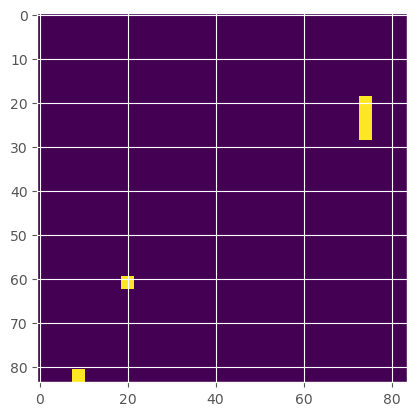

In [21]:
plt.imshow(faulty_batch[0][0])
plt.show()